## 연어

### 시장별 가격 절대값의 시계열 의존성 확인

In [4]:
import pandas as pd
import numpy as np
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.stattools import acf, q_stat
import matplotlib.pyplot as plt


#한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [5]:

# CSV 읽기
df = pd.read_csv('pp/연어_price_data.csv')

# 날짜 형식 변환
df['priceDate'] = pd.to_datetime(df['priceDate'])


In [6]:
# 분석할 시차들
lags = [1, 2, 3, 7, 15]

# 각 시장별로 분석
markets = df['market'].unique()
results = []

for market in markets:
    market_data = df[df['market'] == market].sort_values('priceDate')
    
    if len(market_data) < max(lags) + 1:
        continue
        
    # 1. Durbin-Watson 검정
    dw_stat = durbin_watson(market_data['avgPrice'].dropna())
    
    # 2. 자기상관계수
    acf_values = acf(market_data['avgPrice'].dropna(), nlags=max(lags))
    
    # 3. Ljung-Box 검정 (q_stat 사용)
    _, p_values = q_stat(acf_values[1:], len(market_data['avgPrice'].dropna()))
    lb_pvalues = p_values[np.array(lags)-1]  # lag에 해당하는 p-value만 선택
    
    result = {
        'market': market,
        'n_samples': len(market_data),
        'durbin_watson': dw_stat,
    }
    
    # 각 시차별 자기상관계수와 Ljung-Box p-value 추가
    for i, lag in enumerate(lags):
        result[f'acf_lag_{lag}'] = acf_values[lag]
        result[f'lb_pvalue_lag_{lag}'] = lb_pvalues[i]
    
    results.append(result)

In [7]:
# 결과를 데이터프레임으로 변환
results_df = pd.DataFrame(results)

print("\n=== 시장별 시계열 의존성 분석 결과 ===")
print("\n1. Durbin-Watson 통계량 (2에 가까울수록 독립적, 0 또는 4에 가까울수록 의존적)")
print(results_df[['market', 'durbin_watson']].to_string(index=False))

print("\n2. 시차별 자기상관계수 (절대값이 클수록 의존성이 강함)")
acf_columns = [col for col in results_df.columns if col.startswith('acf_lag_')]
print(results_df[['market'] + acf_columns].to_string(index=False))

print("\n3. 시차별 Ljung-Box 검정 p-value (0.05 미만이면 시계열 의존성이 있다고 판단)")
lb_columns = [col for col in results_df.columns if col.startswith('lb_pvalue_')]
print(results_df[['market'] + lb_columns].to_string(index=False))


=== 시장별 시계열 의존성 분석 결과 ===

1. Durbin-Watson 통계량 (2에 가까울수록 독립적, 0 또는 4에 가까울수록 의존적)
     market  durbin_watson
       가락시장       0.005565
   강서농수산물시장       0.002537
   구리농수산물시장       0.001034
     노량진 1층       0.001080
     노량진 2층       0.002378
   마포농수산물시장       0.000184
  소래포구종합어시장       0.003752
   수원농수산물시장       0.001779
 안양평촌농수산물시장       0.001409
인천종합연안부두어시장       0.005208

2. 시차별 자기상관계수 (절대값이 클수록 의존성이 강함)
     market  acf_lag_1  acf_lag_2  acf_lag_3  acf_lag_7  acf_lag_15
       가락시장   0.942037   0.948478   0.951202   0.945089    0.936875
   강서농수산물시장   0.980869   0.977382   0.980467   0.971733    0.953775
   구리농수산물시장   0.990944   0.987396   0.984042   0.971607    0.946165
     노량진 1층   0.988641   0.984731   0.983056   0.972747    0.961632
     노량진 2층   0.981634   0.980074   0.981746   0.976533    0.968173
   마포농수산물시장   0.998636   0.997344   0.996113   0.990979    0.981599
  소래포구종합어시장   0.965156   0.961774   0.966828   0.950765    0.940299
   수원농수산물시장   0.972938   0.971597   0.9689

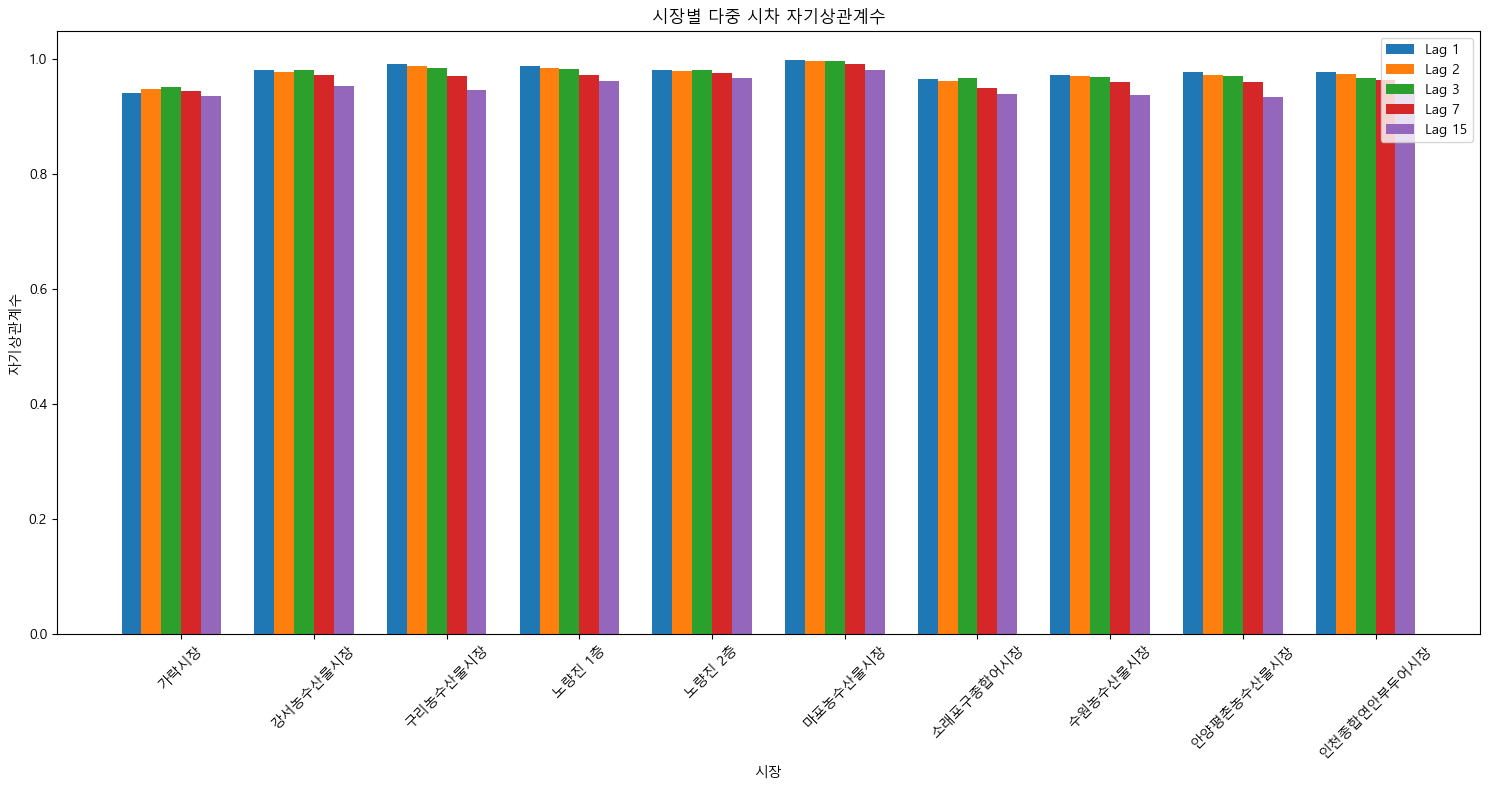

In [8]:
# 각 시장별 자기상관계수 시각화
plt.figure(figsize=(15, 8))
width = 0.15
x = np.arange(len(markets))

for i, lag in enumerate(lags):
    plt.bar(x + width * (i - len(lags)/2), 
            results_df[f'acf_lag_{lag}'], 
            width, 
            label=f'Lag {lag}')
    

plt.xlabel('시장')
plt.ylabel('자기상관계수')
plt.title('시장별 다중 시차 자기상관계수')
plt.xticks(x, markets, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

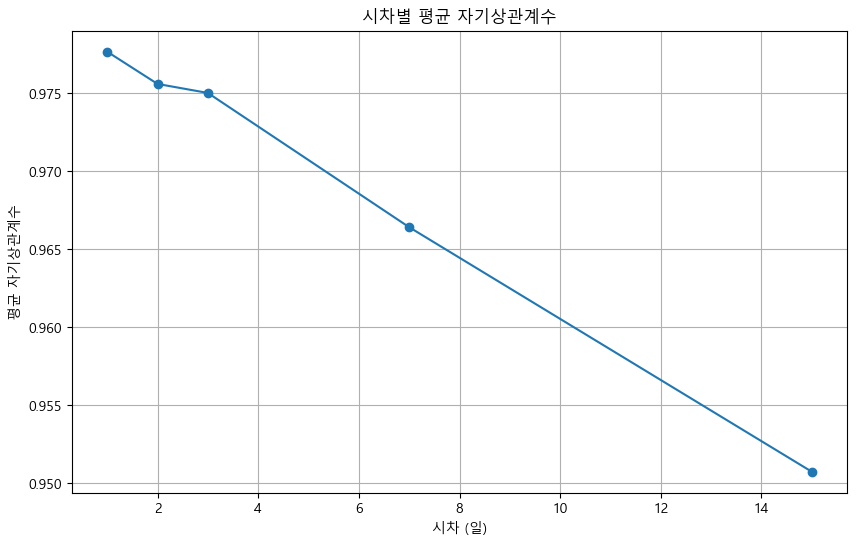

In [9]:
# 시차별 자기상관계수 평균 비교
acf_means = [results_df[f'acf_lag_{lag}'].mean() for lag in lags]
plt.figure(figsize=(10, 6))
plt.plot(lags, acf_means, marker='o')
plt.xlabel('시차 (일)')
plt.ylabel('평균 자기상관계수')
plt.title('시차별 평균 자기상관계수')
plt.grid(True)
plt.show()

### 시장별 가격 변화율의 시계열 의존성 확인

In [10]:
import pandas as pd
import numpy as np
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.stattools import acf, q_stat
import matplotlib.pyplot as plt

#한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [11]:
# CSV 읽기
df = pd.read_csv('pp/연어_price_data.csv')

# 날짜 형식 변환
df['priceDate'] = pd.to_datetime(df['priceDate'])

In [12]:
# 분석할 시차들
lags = [1, 2, 3, 7, 15]

# 각 시장별로 분석
markets = df['market'].unique()
results = []

for market in markets:
    market_data = df[df['market'] == market].sort_values('priceDate')
    
    if len(market_data) < max(lags) + 1:
        continue
    
    # 일별 변화율 계산 (퍼센트)
    market_data['returns'] = market_data['avgPrice'].pct_change() * 100
        
    # 1. Durbin-Watson 검정
    dw_stat = durbin_watson(market_data['returns'].dropna())
    
    # 2. 자기상관계수
    acf_values = acf(market_data['returns'].dropna(), nlags=max(lags))
    
    # 3. Ljung-Box 검정 (q_stat 사용)
    _, p_values = q_stat(acf_values[1:], len(market_data['returns'].dropna()))
    lb_pvalues = p_values[np.array(lags)-1]  # lag에 해당하는 p-value만 선택
    
    result = {
        'market': market,
        'n_samples': len(market_data['returns'].dropna()),
        'durbin_watson': dw_stat,
    }
    
    # 각 시차별 자기상관계수와 Ljung-Box p-value 추가
    for i, lag in enumerate(lags):
        result[f'acf_lag_{lag}'] = acf_values[lag]
        result[f'lb_pvalue_lag_{lag}'] = lb_pvalues[i]
        
	# 변화율의 기본 통계량 추가
    result.update({
        'mean_return': market_data['returns'].mean()
    })
        
    results.append(result)

In [13]:
# 결과를 데이터프레임으로 변환
results_df = pd.DataFrame(results)

print("\n=== 시장별 가격 변화율의 시계열 의존성 분석 결과 ===")

print("\n1. Durbin-Watson 통계량 (2에 가까울수록 독립적, 0 또는 4에 가까울수록 의존적)")
print(results_df[['market', 'durbin_watson']].to_string(index=False))

print("\n2. 시차별 자기상관계수 (절대값이 클수록 의존성이 강함)")
acf_columns = [col for col in results_df.columns if col.startswith('acf_lag_')]
print(results_df[['market'] + acf_columns].to_string(index=False))

print("\n3. 시차별 Ljung-Box 검정 p-value (0.05 미만이면 시계열 의존성이 있다고 판단)")
lb_columns = [col for col in results_df.columns if col.startswith('lb_pvalue_')]
print(results_df[['market'] + lb_columns].to_string(index=False))


=== 시장별 가격 변화율의 시계열 의존성 분석 결과 ===

1. Durbin-Watson 통계량 (2에 가까울수록 독립적, 0 또는 4에 가까울수록 의존적)
     market  durbin_watson
       가락시장       3.027318
   강서농수산물시장       2.859280
   구리농수산물시장       2.579645
     노량진 1층       2.665704
     노량진 2층       2.824922
   마포농수산물시장       2.144261
  소래포구종합어시장       2.886618
   수원농수산물시장       2.950820
 안양평촌농수산물시장       2.787892
인천종합연안부두어시장       2.801799

2. 시차별 자기상관계수 (절대값이 클수록 의존성이 강함)
     market  acf_lag_1  acf_lag_2  acf_lag_3  acf_lag_7  acf_lag_15
       가락시장  -0.515112   0.035607   0.061070   0.029750    0.073017
   강서농수산물시장  -0.430411  -0.163807   0.174179   0.043950   -0.083617
   구리농수산물시장  -0.290202  -0.006797  -0.043311  -0.005839   -0.015264
     노량진 1층  -0.333206  -0.051226   0.043480  -0.115397    0.163406
     노량진 2층  -0.413340  -0.066862   0.090474  -0.038547    0.102527
   마포농수산물시장  -0.072374  -0.037112   0.040548  -0.003816    0.047616
  소래포구종합어시장  -0.445085  -0.078748   0.207328  -0.013923   -0.070806
   수원농수산물시장  -0.476288   0.012216 

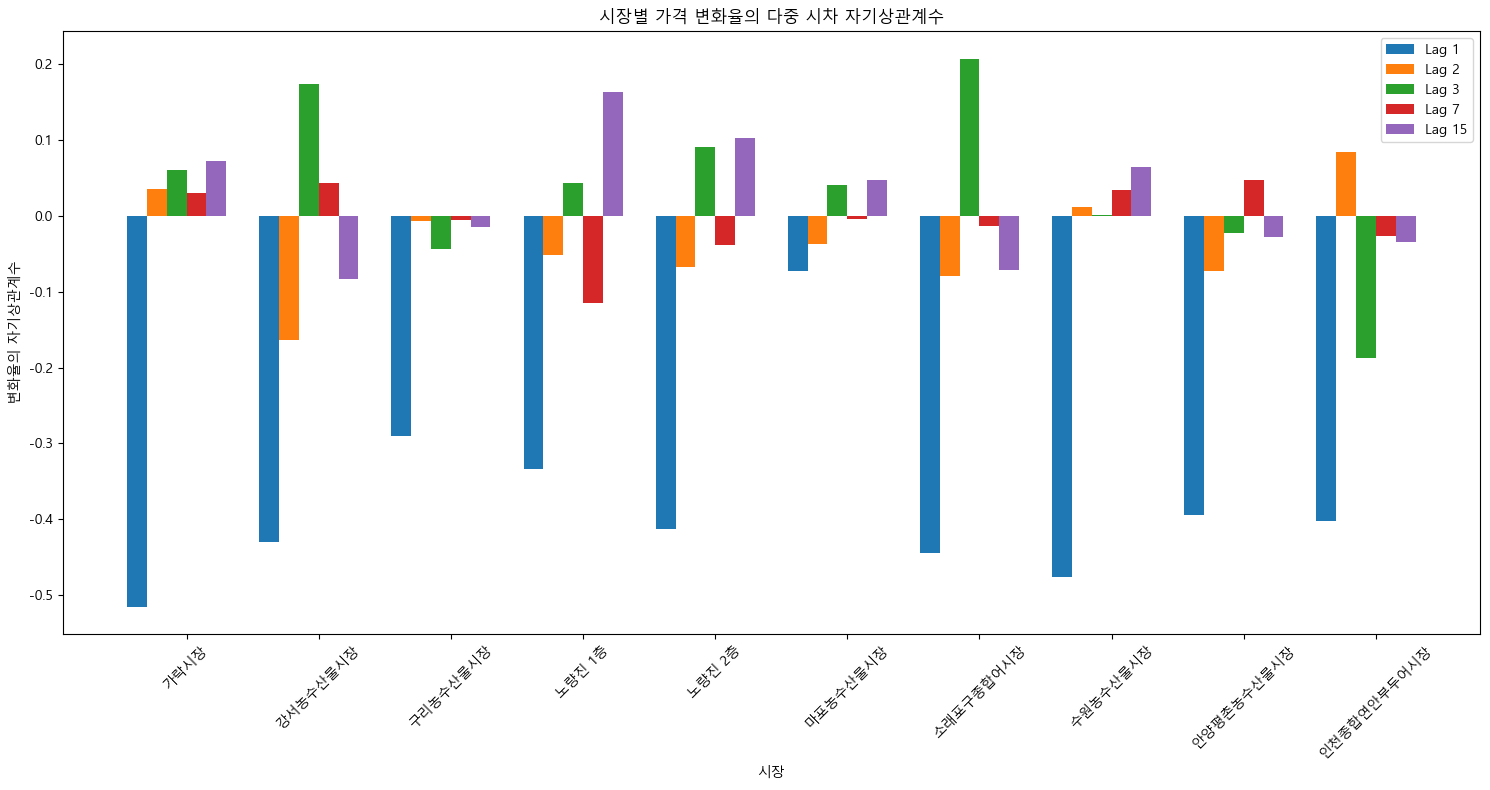

In [14]:

# 각 시장별 자기상관계수 시각화
plt.figure(figsize=(15, 8))
width = 0.15
x = np.arange(len(markets))

for i, lag in enumerate(lags):
    plt.bar(x + width * (i - len(lags)/2), 
            results_df[f'acf_lag_{lag}'], 
            width, 
            label=f'Lag {lag}')

plt.xlabel('시장')
plt.ylabel('변화율의 자기상관계수')
plt.title('시장별 가격 변화율의 다중 시차 자기상관계수')
plt.xticks(x, markets, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

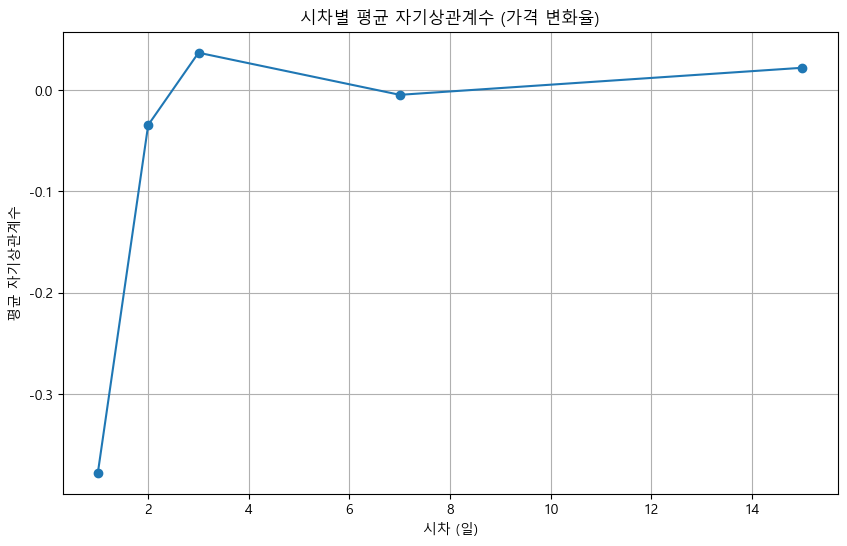

In [15]:


# 시차별 자기상관계수 평균 비교
acf_means = [results_df[f'acf_lag_{lag}'].mean() for lag in lags]
plt.figure(figsize=(10, 6))
plt.plot(lags, acf_means, marker='o')
plt.xlabel('시차 (일)')
plt.ylabel('평균 자기상관계수')
plt.title('시차별 평균 자기상관계수 (가격 변화율)')
plt.grid(True)
plt.show()

### 결과 해석

* 시장 가격 절대값과 변화율 모두 높은 자기 상관계수를 보이는 것으로 보아, 시계열 의존성이 있다고 판단
* Durbin-Watson: 연속된 시점(lag 1)의 선형 관계만 검정이고 , Ljung-Box: 여러 시차에 걸친 비선형적 관계까지 포괄적으로 검정이기에 결과에 차이가 나타난다
* 의존성의 종류와 강도
	- 선형적 의존성은 약함 (Durbin-Watson으로 확인)
	- 비선형적 의존성은 존재 (Ljung-Box로 확인)
	- 복합적인 시차 관계가 존재할 수 있음

~결론~	시계열 의존성이 있다고 봐야 함    
단, 그 의존성은 단순한 선형관계가 아닐 수 있음  
특히 단기(1일) 반전 패턴과 함께 복잡한 패턴이 존재할 가능성